# Bibliotecas

In [43]:
import sys

sys.path.append('/eos/user/t/thenriqu/Dark_Matter/LGBM_hhdm_analysis/')

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import hepherolib.data as data
import hepherolib.analysis as ana
from sklearn.model_selection import train_test_split

from hhdm_analysis.utils import position
from lgbm.controllers_lgbm import LGBLearner, LGBModel

ana.start()
plt.style.use("default")

# Configuração

In [44]:
period = '18'
year_style = 2018
dataset_year = "2018"
basedir = '/eos/user/t/thenriqu/Dark_Matter/Amostras/hhdmAnalysis_deepJet_Regions/datasets'
dataset_name = basedir.split('/')[-2]

# Setup output folders
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)


# Lendo Metadata

In [45]:
with open("/eos/user/t/thenriqu/Dark_Matter/metadata.json", "r") as f:
    metadata = json.load(f)

ST = metadata.get("datasets").get("ST")
TT = metadata.get("datasets").get("TT")
ZZ = metadata.get("datasets").get("ZZ")
WZ = metadata.get("datasets").get("WZ")
DY = metadata.get("datasets").get("DY")
RESIDUAL = metadata.get("datasets").get("RESIDUAL")
DATA = metadata.get("datasets").get("DATA")



In [46]:
pd.DataFrame(TT)

,16,APV_16,17,18
0,TTTo2L2Nu,TTTo2L2Nu,TTTo2L2Nu,TTTo2L2Nu
1,TTToSemiLeptonic,TTToSemiLeptonic,TTToSemiLeptonic,TTToSemiLeptonic


# Lendo os dados

In [47]:
variables = ["RegionID", "evtWeight", "LeadingLep_pt", "LepLep_pt", "LepLep_deltaR", "LepLep_deltaM", "MET_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "TrailingLep_pt", "MT2LL", "Nbjets"]
ds = data.read_files(basedir, period, mode="normal", features=variables)
data.join_datasets(ds, "ST", ST.get(period), mode="normal")
data.join_datasets(ds, "TT", TT.get(period), mode="normal")
data.join_datasets(ds, "ZZ", ZZ.get(period), mode="normal")
data.join_datasets(ds, "WZ", WZ.get(period), mode="normal")
data.join_datasets(ds, "DYJetsToLL", DY.get(period), mode="normal")
data.join_datasets(ds, "Residual", RESIDUAL.get(period), mode="normal")
# data.join_datasets(ds, "LeadingLep_pt", LL.get(period), mode="normal")


# Datasets to be used
used_datasets = ["Signal_400_100", "Signal_1000_100", "ST", "TT", "ZZ", "WZ", "DYJetsToLL", "Residual"]

for dt_name in used_datasets:
    print(dt_name, ds[dt_name].shape)

# Delete every other dataset
datasets_to_delete = [dt_name for dt_name in ds.keys() if dt_name not in used_datasets]
for dt_name in datasets_to_delete:
    del ds[dt_name]


Loading datasets...


100%|██████████| 73/73 [00:02<00:00, 34.10it/s]


Signal_400_100 (112655, 12)
Signal_1000_100 (184662, 12)
ST (94330, 12)
TT (2647163, 12)
ZZ (1924672, 12)
WZ (24816, 12)
DYJetsToLL (5897214, 12)
Residual (537577, 12)


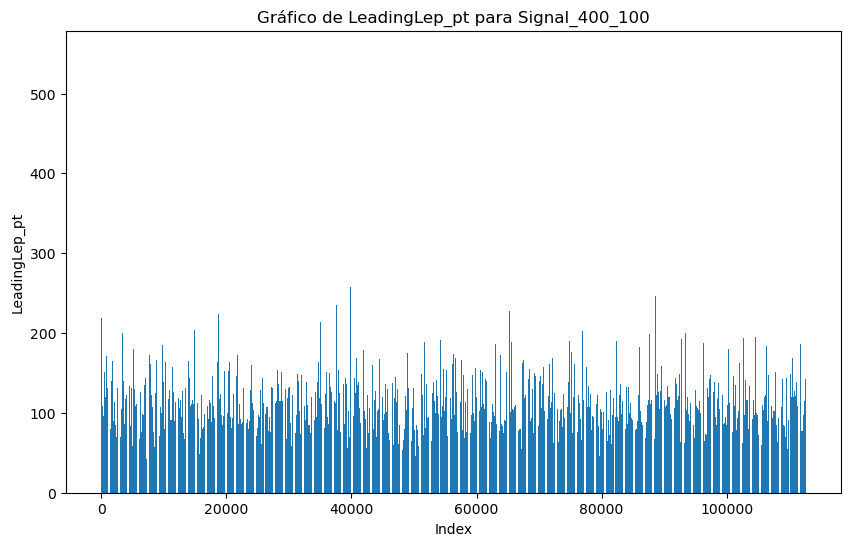

In [55]:
# Supondo que 'ds' seja um dicionário onde cada valor é um DataFrame do pandas
variable_name = "LeadingLep_pt"
dt_name = "Signal_400_100"  # Por exemplo, escolha um dos DataFrames

plt.figure(figsize=(10, 6))
plt.bar(ds[dt_name].index, ds[dt_name][variable_name])
plt.xlabel('Index')
plt.ylabel(variable_name)
plt.title(f'Gráfico de {variable_name} para {dt_name}')
plt.show()


# Pre-processamento dos datasets

In [5]:
# Used for scaling the weights (this helps xgboost)
scale_factor = 10**6

# Filtering SR
ds = {k: v[v.RegionID == 0] for k,v in ds.items()}

# Selecting backgrounds and signals
model_name = "LGB_multi_signal"
signals_to_use = [key for key in ds.keys() if "Signal_" in key]
signals = [ds[key] for key in signals_to_use]
backgrounds = [ds["ST"], ds["TT"], ds["ZZ"], ds["WZ"], ds["DYJetsToLL"], ds["Residual"]]

# Remove negative values
backgrounds = [bkg[bkg.evtWeight >= 0] for bkg in backgrounds]
signals = [signal[signal.evtWeight >= 0] for signal in signals]

# Labeling
for bkg in backgrounds:
    bkg.loc[:, "Label"] = 0
for signal in signals:
    signal.loc[:, "Label"] = 1

# Generate train and test data pre-processing weights
datasets = [*signals, pd.concat(backgrounds)]
train_dataset = []
test_dataset = []

for dataset in datasets:
    df_train, df_test = train_test_split(dataset, test_size=0.3, random_state=42)
    
    # Scale event weight by train/test split
    train_factor = dataset.evtWeight.sum() / df_train.evtWeight.sum()
    test_factor = dataset.evtWeight.sum() / df_test.evtWeight.sum()
    df_train["evtWeight"] = df_train.evtWeight * train_factor 
    df_test["evtWeight"] = df_test.evtWeight * test_factor
    
    # Normalize weights
    df_train["modelWeight"] = df_train.evtWeight / df_train.evtWeight.sum()
    df_test["modelWeight"] = df_test.evtWeight / df_test.evtWeight.sum()
    
    train_dataset.append(df_train)
    test_dataset.append(df_test)

# Group train and test
train_dataset = pd.concat(train_dataset)
test_dataset = pd.concat(test_dataset)

# Re-normalize
train_dataset["modelWeight"] = scale_factor*(train_dataset.modelWeight / train_dataset.modelWeight.sum())
test_dataset["modelWeight"] = scale_factor*(test_dataset.modelWeight / test_dataset.modelWeight.sum())

# Shuffle
train_dataset = train_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
test_dataset = test_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipykernel_913/349794702.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkg.loc[:, "Label"] = 0
/tmp/ipykernel_913/349794702.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bkg.loc[:, "Label"] = 0
/tmp/ipykernel_913/349794702.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

# Plot - Distribuição

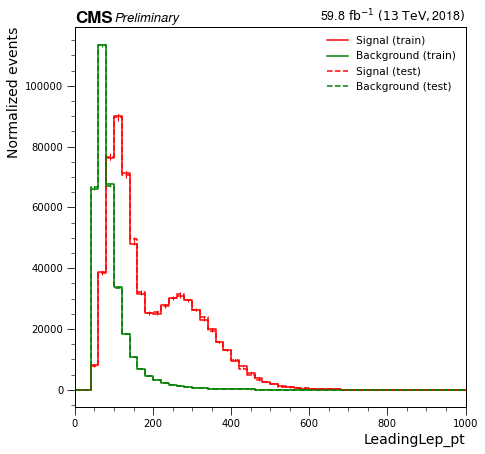

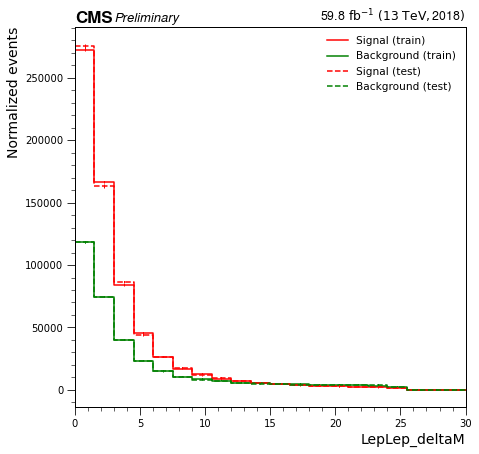

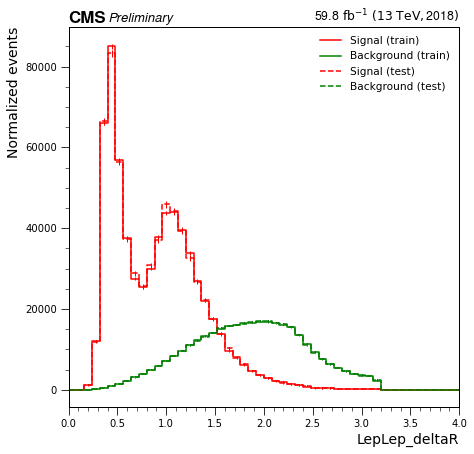

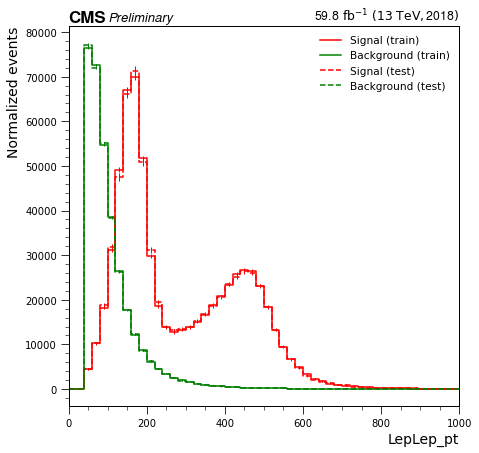

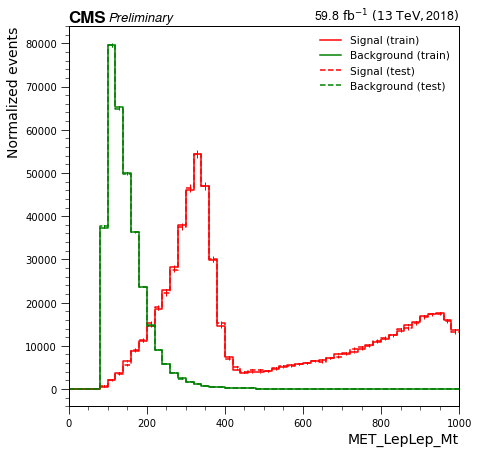

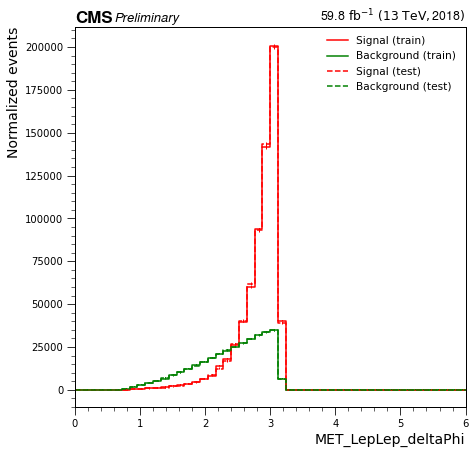

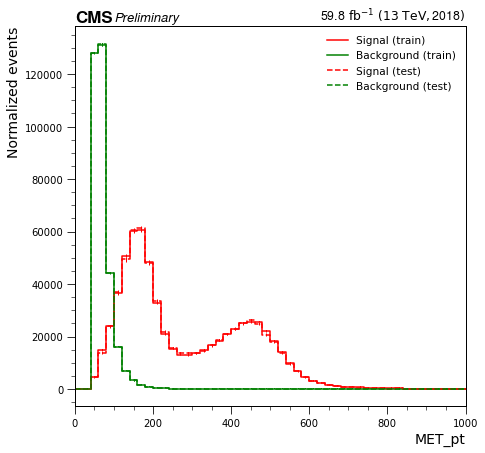

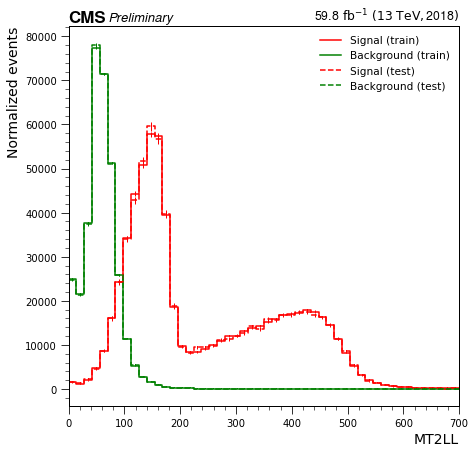

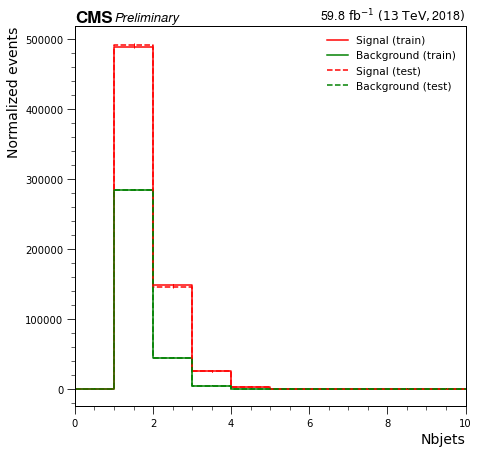

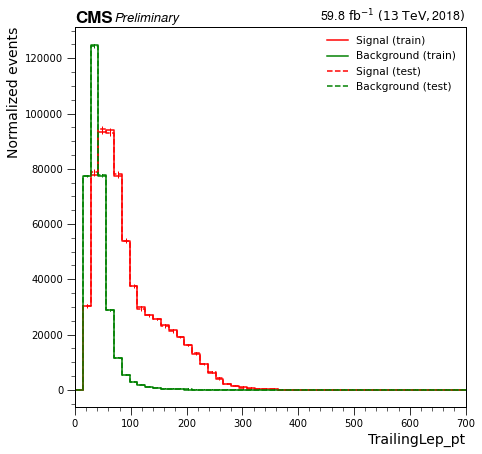

In [6]:
features = [
    ('LeadingLep_pt', 'LeadingLep_pt', 0, 1000, 51, 5001),
    ('LepLep_deltaM', 'LepLep_deltaM', 0, 30, 21, 5001),
    ('LepLep_deltaR', 'LepLep_deltaR', 0, 4, 51, 5001),
    ('LepLep_pt', 'LepLep_pt', 0, 1000, 51, 5001),
    ('MET_LepLep_Mt', 'MET_LepLep_Mt', 0, 1000, 51, 5001),
    ("MET_LepLep_deltaPhi", "MET_LepLep_deltaPhi", 0, 6, 51, 5001),
    ('MET_pt', 'MET_pt', 0, 1000, 51, 5001),
    ("MT2LL", "MT2LL", 0, 700, 51, 5001),
    ("Nbjets", "Nbjets", 0, 10, 11, 5001),
    ("TrailingLep_pt", "TrailingLep_pt", 0, 700, 51, 5001)
]


for feature in features:
    bins = np.linspace(feature[2], feature[3], feature[4])
    
    # Plot config
    fig = plt.figure(figsize=(7,7))
    grid = [1,1] # number of rows, number of cols
    gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

    # Plot code
    ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number

    ana.step_plot(ax1, feature[0], train_dataset[train_dataset.Label == 1], label=f"Signal (train)", color="red", weight="modelWeight", bins=bins, error=True)
    ana.step_plot(ax1, feature[0], train_dataset[train_dataset.Label == 0], label=f"Background (train)", color="green", weight="modelWeight", bins=bins, error=True)
    ana.step_plot(ax1, feature[0], test_dataset[test_dataset.Label == 1], label=f"Signal (test)", color="red", weight="modelWeight", bins=bins, linestyle="--", error=True)
    ana.step_plot(ax1, feature[0], test_dataset[test_dataset.Label == 0], label=f"Background (test)", color="green", weight="modelWeight", bins=bins, linestyle="--", error=True)
    
    ana.labels(ax1, ylabel="Normalized events", xlabel=feature[1])
    ana.style(
        ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
        ylog=False, legend_ncol=1,
    )
    plt.show()
    plt.close()

# Salvando os dados - Treino e Teste

In [7]:
# Pop unused variables at this point
train_dataset.pop("RegionID")
test_dataset.pop("RegionID")

train_dataset.to_csv(f"{data_path}/{model_name}-train-data.csv", index=False)
test_dataset.to_csv(f"{data_path}/{model_name}-test-data.csv", index=False)